In [1]:
from os import listdir
import os, random, copy
from PIL import Image
import numpy as np
from collections import defaultdict
import math

In [2]:
#define sigmoid and its derivative for activation & backprop
def sigmoid(x):
    return 1 / (1 + np.exp(-1 * x))

def derivSigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

## Question 1 - Import Data

In [3]:
################################################################################
# CSE 253: Programming Assignment 1
# Code snippet by Michael
# Winter 2020
################################################################################
# We've provided you with the dataset in PA1.zip
################################################################################
# To install PIL, refer to the instructions for your system:
# https://pillow.readthedocs.io/en/5.2.x/installation.html
################################################################################
# If you don't have NumPy installed, please use the instructions here:
# https://scipy.org/install.html
################################################################################


''' 
list of face expressions (contempt, neutral are excluded) are:
1. anger
2. disgust
3. fear
4. happiness
5. sadness
6. surprise
'''

def load_data(data_dir="./aligned/"):
	""" Load all PNG images stored in your data directory into a list of NumPy
	arrays.

	Args:
		data_dir: The relative directory path to the CK+ image directory.
	Returns:
		images: A dictionary with keys as emotions and a list containing images associated with each key.
		cnt: A dictionary that stores the # of images in each emotion
	"""
	images = defaultdict(list)

	# Get the list of emotional directory:
	for e in listdir(data_dir):
		# excluding any non-directory files
		if not os.path.isdir(os.path.join(data_dir, e)):
			continue
		# Get the list of image file names
		all_files = listdir(os.path.join(data_dir, e))

		for file in all_files:
			# Load only image files as PIL images and convert to NumPy arrays
			if '.png' in file:
				img = Image.open(os.path.join(data_dir, e, file))
				images[e].append(np.array(img))

	print("Emotions: {} \n".format(list(images.keys())))

	cnt = defaultdict(int)
	for e in images.keys():
		print("{}: {} # of images".format(e, len(images[e])))
		cnt[e] = len(images[e])
	return images, cnt

def balanced_sampler(dataset, cnt, emotions):
	# this ensures everyone has the same balanced subset for model training, don't change this seed value
	random.seed(20)
	print("\nBalanced Set:")
	min_cnt = min([cnt[e] for e in emotions])
	balanced_subset = defaultdict(list)
	for e in emotions:
		balanced_subset[e] = copy.deepcopy(dataset[e])
		random.shuffle(balanced_subset[e])
		balanced_subset[e] = balanced_subset[e][:min_cnt]
		print('{}: {} # of images'.format(e, len(balanced_subset[e])))
	return balanced_subset

def display_face(img):
	""" Display the input image and optionally save as a PNG.

	Args:
		img: The NumPy array or image to display

	Returns: None
	"""
	# Convert img to PIL Image object (if it's an ndarray)
	if type(img) == np.ndarray:
		print("Converting from array to PIL Image")
		img = Image.fromarray(img)

	# Display the image
	img.show()


# example on how to use it
if __name__ == '__main__':
	# The relative path to your image directory
	data_dir = "./aligned/"
	dataset, cnt = load_data(data_dir)
	# test with happiness and anger
	images = balanced_sampler(dataset, cnt, emotions=['happiness', 'anger'])
	display_index = 0
	display_face(images['anger'][display_index])

Emotions: ['fear', 'surprise', 'sadness', 'happiness', 'anger', 'disgust'] 

fear: 25 # of images
surprise: 83 # of images
sadness: 28 # of images
happiness: 69 # of images
anger: 45 # of images
disgust: 59 # of images

Balanced Set:
happiness: 45 # of images
anger: 45 # of images
Converting from array to PIL Image


In [4]:
K = 10 # number of sections after folding
M = 50 # maximum number of epochs


## Training Procedure

In [5]:
#list happiness as a 1, anger as a 0
X = images['happiness'] + images['anger']
y = [1] * 45 + [0] * 45

#get my feature - label pairs zipped together
all_happy_angry = list(zip(X,y))

#randomize the dataset so I can fold properly

random.shuffle(all_happy_angry)

def kfold(data, k=10):
    folds = []
    size = int((1/k) * len(data))
    for i in range(0,k):
        folds.append(data[i*size : (i+1)*size])
    return folds


In [6]:
folds = kfold(all_happy_angry)
print(len(folds[0]) == len(folds[1]))
print(len(folds))

True
10


## Task 5 - Logistic Regression

In [33]:
class LogisticRegression:
    
    def __init__(self, lr, dim):
        self.lr = lr
        self.w = np.zeros(dim) 
    
    def stochastic_gradient_descent(self, X, labels):
        indices = [i for i in range(len(labels))]
        np.random.shuffle(indices)
        for i in indices:
            
            # make predition
            data = X[i]
            label = labels[i]
            predicted = sigmoid(data.dot(self.w))
            error = label - predicted
            
            # update weights
            for i in range(len(self.w)):
                grad = error * data[i]
                self.w[i] += self.lr * grad
            
    def probabilities(self, X):
        return sigmoid(X.dot(self.w))

    
    def batch_gradient_descent(self, X, labels):
        predicted = self.probabilities(X)
        error = labels - predicted
        grad = X.T.dot(error)
        self.w += self.lr * grad
        

    def loss(self, labels, predicted):
        log_predicted = np.log(predicted)
        cost = log_predicted*labels + (1 - labels) * log_predicted
        return - cost.sum() / len(labels)


In [34]:
lr = LogisticRegression(0.1, 3)

In [35]:
lr.loss(np.array([1,1]), np.array([1,1]))

-0.0

In [36]:
lr.loss(np.array([1,1]), np.array([0.5,1]))

0.34657359027997264

In [37]:
test_data = np.array([[0.9,0.22,0.44], [0.0,0.22,0.44]])

for i in range(50):
    lr.stochastic_gradient_descent(test_data, np.array([0, 1]))

In [38]:
lr.w

array([-1.52279355,  0.16095488,  0.32190976])

In [39]:
lr.probabilities(test_data)

array([0.23264001, 0.54414733])

In [41]:
lr.loss(np.array([0, 1]), lr.probabilities(test_data))

1.0333991525889226

In [42]:
5 

[0, 0, 0, 0, 1, 0]

[0, 0, 0, 0, 1, 0]

## Softmax

In [28]:
emotions_mapping = ["fear", "surprise", "sadness", "happiness", "anger", "disgust"]


class SoftmaxRegression:
    
    def __init__(self, lr, dim, c):
        self.lr = lr
        self.w = np.zeros((dim, c)) 
    
    def stochastic_gradient_descent(self, X, labels):
        indices = [i for i in range(len(labels))]
        np.random.shuffle(indices)
        for i in indices:
            
            # make predition
            data = X[i]
            label = labels[i]
            predicted = self.probabilities(data)
            error = label - predicted
            
            # update weights
            for i in range(len(self.w)):
                grad = error * data[i]
                self.w[i] += self.lr * grad
            
    def probabilities(self, X):
        return np.exp(X.dot(self.w)) / np.sum(np.exp(X.dot(self.w)), axis=0)

    
    def batch_gradient_descent(self, X, labels):
        predicted = self.probabilities(X)
        error = labels - predicted
        grad = X.T.dot(error)
        self.w += self.lr * grad
        

    def loss(self, labels, predicted):
        return -np.sum(np.sum(labels.T.dot(np.log(predicted)))) # can't have zero values 



In [29]:
softmax = SoftmaxRegression(0.02, 4, 2)

test_data = np.array([[0.3,0.22,0.44, 0.44], [0.0,0.12,0.2, 0.2]])



softmax.loss(np.array([[1, 0],[1,0]]), softmax.probabilities(test_data))

2.772588722239781

In [30]:
for i in range(1000):
    softmax.batch_gradient_descent(test_data, np.array([[1, 0],[1,0]]))

In [31]:
softmax.w

array([[ 1.15572504, -1.15572504],
       [ 2.78524168, -2.78524168],
       [ 4.92458004, -4.92458004],
       [ 4.92458004, -4.92458004]])

In [32]:
softmax.probabilities(test_data)

array([[0.95207653, 0.04792347],
       [0.04792347, 0.95207653]])

Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3


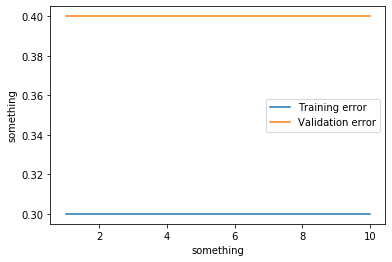

Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3


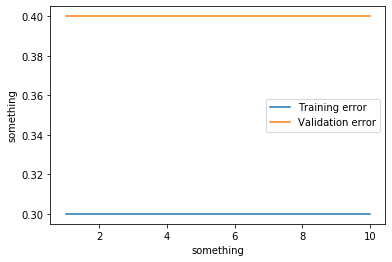

Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3


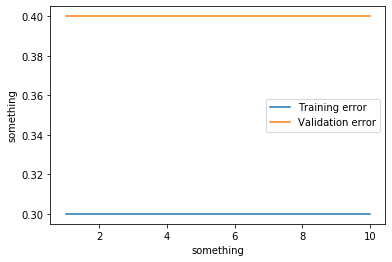

Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3


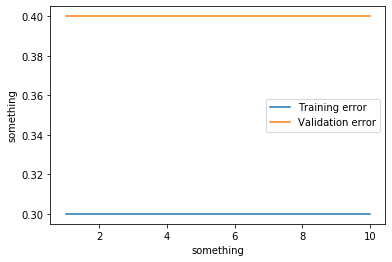

Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3


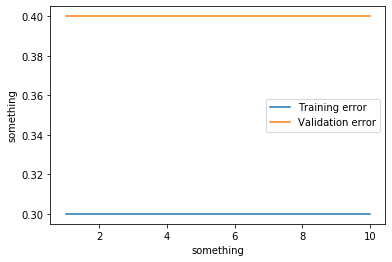

Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3


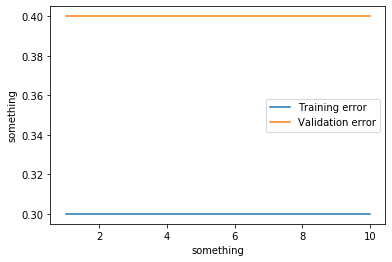

Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3


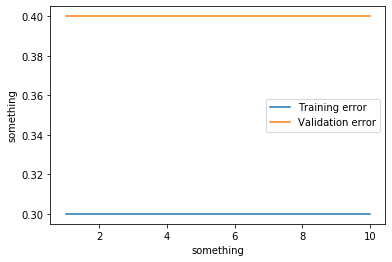

Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3


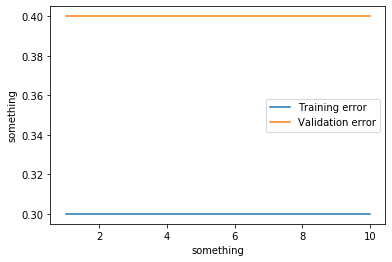

Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3


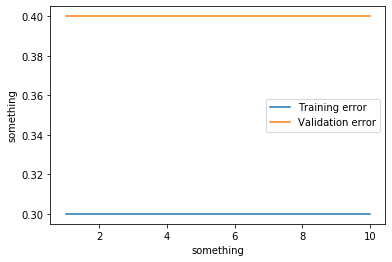

Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3
Training error: 0.5, validation error: 0.6, accuracy: 0.3


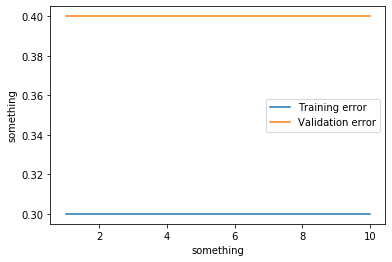

In [92]:
import matplotlib.pyplot as plt
from pca import PCA

EPOCHS = 10

class EpochData:
    def __init__(self):
        self.acc = []
        self.error = []
    
    def save(self, acc, error):
        self.acc.append(acc)
        self.error.append(error)
        
    
    def score(self):
        return self.error[-1]
        

def transform(data):
    # TODO 
    return data

def visualize_data(plots, legends, x_label, y_label):
    x = np.arange(1, len(plots[0]) + 1)
    for data in plots:
        plt.plot(x, data)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.legend(legends)
    plt.show()
    
def split_x_y(data):
    return np.array([item[0] for item in data]), np.array([item[1] for item in data]) 


def train():
    best_model = None
    
    folds = kfold(all_happy_angry)
    k = len(folds)
    for fold in range(k):
        model = LogisticRegression(0.2, 1) # model
        
        # split data
        val_data, test_data = split_x_y(folds[fold]), split_x_y(folds[(fold + 1) % k])
        train_data = None
        for i in range(k):
            if i is not fold or i is not ((fold + 1) % k):
                if train_data is None:
                    train_data = folds[i]
                else:
                    train_data = np.concatenate((train_data, folds[i]))
        train_data = split_x_y(train_data)

        
        # PCA
        train_data, train_data, train_data = transform(train_data), transform(test_data), transform(val_data)
        
        validation_performance = EpochData()
        training_performance = EpochData()    
        
        for epoch in range(EPOCHS):
            #model.batch_gradient_descent()
            
            training_error = 0.5 # model.loss()
            validation_error = 0.6 #model.loss()
            
            traning_acc = 0.3 #model.make_prediction()
            validation_acc = 0.4 #model.make_prediction()
            
            print("Training error: {}, validation error: {}, accuracy: {}".format(training_error, validation_error, traning_acc))
        
            # save
            validation_performance.save(validation_error, validation_acc)
            training_performance.save(training_error, traning_acc)
        
        
        # plot the graphs
        data_to_plot = [training_performance.error, validation_performance.error]
        legends = ["Training error", "Validation error"]
        visualize_data(data_to_plot,legends, "something", "something")
        
        # save the best model
        
        # save the validation data to the model
        model.epoch_data = validation_performance 
        
        if best_model is None:
            best_model = model
        elif best_model.epoch_data.score() > model.epoch_data.score():
            best_model = model
        
            

def test():
    pass

train()
#training_procedure()
